In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Exercise 1: Image derivatives

$I_{y}(x,y) = g(x)*\frac{d}{dy}g(y)*I(x,y)$

$I_{yy}(x,y) = g(x)*\frac{d}{dy}g(y)*I_y(x,y)$

$I_{xy}(x,y) = g(x)*\frac{d}{dy}g(y)*I_x(x,y)$

In [5]:
def gauss(x, sigma=1):
	g = np.exp(-x**2 / (2*sigma**2)) / (sigma*np.sqrt(2*np.pi))
	return g
def gaussdx_point(w, sigma=1):
	g = -w * np.exp(-w**2 / (2*sigma**2)) / (sigma**3*np.sqrt(2*np.pi))
	return g

def gaussian_kernel(sigma):
	tris = np.ceil(3*sigma)
	x = np.arange(-tris, tris+1)
	g = gauss(x, sigma)
	return (g / np.sum(g)).reshape(1, int(2*tris+1))

def gaussdx(sigma):
	tris = np.ceil(3*sigma)
	x = np.arange(-tris, tris+1)
	g = gaussdx_point(x, sigma)
	return (g / np.sum(np.abs(g))).reshape(1, int(2*tris+1))

In [6]:
impulse = np.zeros((25,25))
impulse[12,12] = 255

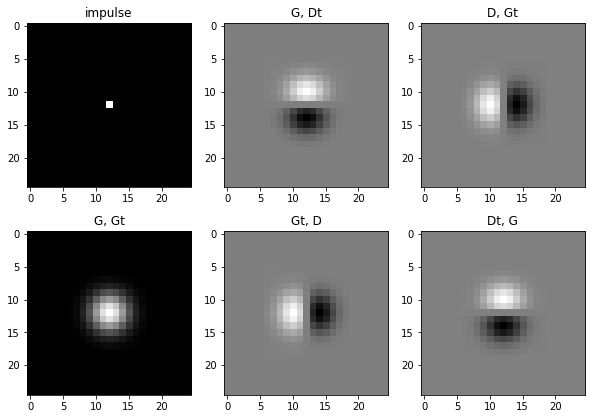

In [7]:
sigma = 2

G = gaussian_kernel(sigma)
D = gaussdx(sigma)

I2 = cv2.filter2D(impulse, -1, G)
I2 = cv2.filter2D(I2, -1, G.T)

I3 = cv2.filter2D(impulse, -1, G)
I3 = cv2.filter2D(I3, -1, np.flip(D.T))

I4 = cv2.filter2D(impulse, -1, G.T)
I4 = cv2.filter2D(I4, -1, np.flip(D))

I5 = cv2.filter2D(impulse, -1, np.flip(D))
I5 = cv2.filter2D(I5, -1, G.T)

I6 = cv2.filter2D(impulse, -1, np.flip(D.T))
I6 = cv2.filter2D(I6, -1, G)


plt.rcParams["figure.figsize"] = (10,7)

plt.subplot(231)
plt.title("impulse")
plt.imshow(impulse, cmap="gray")

plt.subplot(234)
plt.title("G, Gt")
plt.imshow(I2, cmap="gray")

plt.subplot(232)
plt.title("G, Dt")
plt.imshow(I3, cmap="gray")

plt.subplot(235)
plt.title("Gt, D")
plt.imshow(I4, cmap="gray")

plt.subplot(233)
plt.title("D, Gt")
plt.imshow(I5, cmap="gray")

plt.subplot(236)
plt.title("Dt, G")
plt.imshow(I6, cmap="gray")

In [8]:
def partial_d(img, dir="x", sigma=1):
	G = gaussian_kernel(sigma)
	D = gaussdx(sigma)
	if dir == "y":
		G = G.T
		D = D.T

	Id = cv2.filter2D(img, -1, G.T)
	Id = cv2.filter2D(Id, -1, np.flip(D))
	return Id

def partial_2d(img, dir1="x", dir2="x", sigma=1):
	Id = cv2.filter2D(img, -1, G.T)
	I2d = partial_d(Id, dir2, sigma)
	return I2d

def gradient_magnitude(img, sigma=1):
	Ix = partial_d(img, "x", sigma)
	Iy = partial_d(img, "y", sigma)
	m = np.sqrt(Ix**2 + Iy**2)
	phi = np.arctan2(Iy, Ix)
	return m, phi

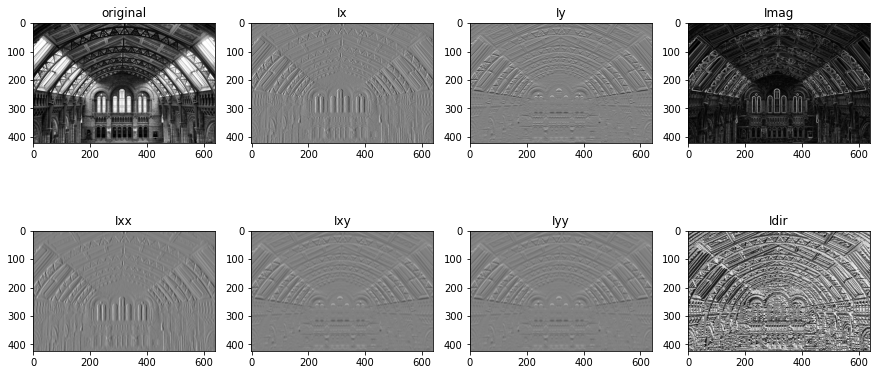

In [9]:
I = cv2.imread("./images/museum.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY).astype("float")


plt.rcParams["figure.figsize"] = (15,7)

plt.subplot(241)
plt.title("original")
plt.imshow(I, vmin=0, vmax=255, cmap="gray")

plt.subplot(242)
plt.title("Ix")
Ix = partial_d(I, "x")
plt.imshow(Ix+128, vmin=0, vmax=255, cmap="gray")

plt.subplot(243)
plt.title("Iy")
Iy = partial_d(I, "y")
plt.imshow(Iy+128, vmin=0, vmax=255, cmap="gray")

plt.subplot(244)
plt.title("Imag")
Imag, Idir = gradient_magnitude(I)
plt.imshow(Imag, cmap="gray")

plt.subplot(245)
plt.title("Ixx")
Ixx = partial_2d(I, "x", "x")
plt.imshow(Ixx+128, vmin=0, vmax=255, cmap="gray")

plt.subplot(246)
plt.title("Ixy")
Ixy = partial_2d(I, "x", "y")
plt.imshow(Ixy+128, vmin=0, vmax=255, cmap="gray")

plt.subplot(247)
plt.title("Iyy")
Iyy = partial_2d(I, "y", "y")
plt.imshow(Iyy+128, vmin=0, vmax=255, cmap="gray")

plt.subplot(248)
plt.title("Idir")
plt.imshow(Idir, cmap="gray")

In [11]:
def grad_hist(I):
	Imag, Idir = gradient_magnitude(I)
	hist = np.zeros((8,8,8))
	for i in range(8):
		for j in range(8):
			regM = Imag[int(I.shape[0]*i/8):int(I.shape[0]*(i+1)/8), int(I.shape[1]*j/8):int(I.shape[1]*(j+1)/8)]
			regD = Idir[int(I.shape[0]*i/8):int(I.shape[0]*(i+1)/8), int(I.shape[1]*j/8):int(I.shape[1]*(j+1)/8)]+np.pi
			pi4 = np.pi/4
			for k in range(8):
				hist[i,j,k] = np.sum(regM[(regD >= pi4*k) * (regD < pi4*(k+1))])
	return hist
	
def directory_histograms(directory):
	l = {}
	for img in os.listdir(directory):
		d = os.path.join(directory, img)
		I = cv2.imread(d)
		I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
		h1 = grad_hist(I)
		l[d] = h1.flatten()
	return l

histograms = directory_histograms("dataset")

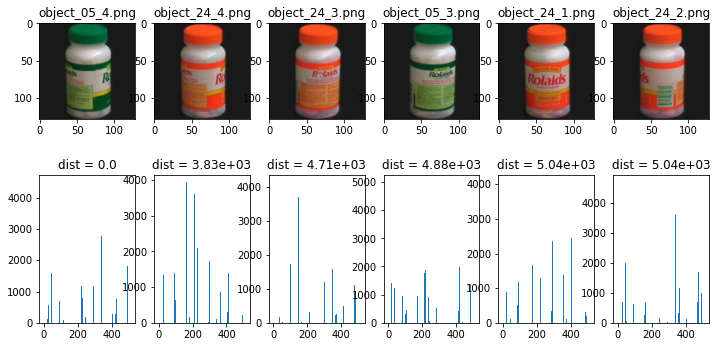

In [12]:
def compare_histograms(H1, H2, metric="L2"):
	if metric.lower() == "l2":
		return np.sqrt(np.sum((H1 - H2)**2))
	elif metric.lower() == "chi":
		return np.sum((H1 - H2)**2 / (H1 + H2 + 1e-10))/2
	elif metric.lower() == "intersection":
		return 1 - np.sum(np.minimum(H1, H2))
	elif metric.lower() == "hellinger":
		return np.sqrt(np.sum((np.sqrt(H1) - np.sqrt(H2))**2)/2)
	else:
		return .0;

def plot_most_similar(histograms):
	selected = histograms["dataset/object_05_4.png"]
	l = []
	for i, (d, hist) in enumerate(histograms.items()):
		dist = compare_histograms(selected, hist, "L2")
		l.append([d, hist, dist, i])

	dists1 = [x[2] for x in l]
	l.sort(key=lambda x: x[2])
	dists2 = [x[2] for x in l]

	n = 6

	plt.rcParams["figure.figsize"] = (12,6)
	for i in range(n):
		I = cv2.imread(l[i][0])
		I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
		plt.subplot(2, n, i+1)
		plt.title(os.path.basename(l[i][0]))
		plt.imshow(I)
		plt.subplot(2, n, n+1+i)
		plt.title("dist = {:.3}".format(l[i][2]))
		plt.bar(np.arange(len(l[i][1])), l[i][1])
	plt.show()
	return l, n, dists1, dists2
l, n, dists1, dists2 = plot_most_similar(histograms)

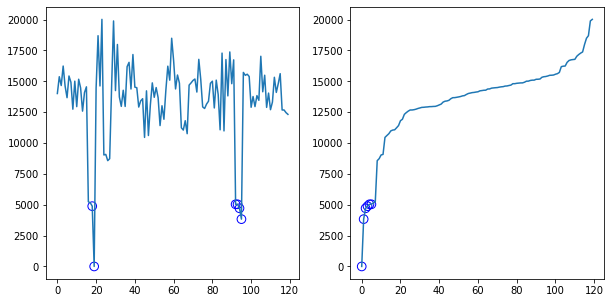

In [13]:
def plot_distance(l,n, dists1, dists2):
	plt.rcParams["figure.figsize"] = (10,5)
	plt.subplot(121)
	plt.plot(dists1)
	plt.scatter([l[i][3] for i in range(n)], [l[i][2] for i in range(n)], s=75, edgecolors="b", facecolors='none')
	plt.subplot(122)
	plt.plot(dists2)
	plt.scatter([i for i in range(n)], [l[i][2] for i in range(n)], s=75, edgecolors="b", facecolors='none')
	plt.show()
plot_distance(l, n, dists1, dists2)

Zdaj pri iskanju podobnih ne upošteva barve, zato je najbolj podobna slika enaka posodice v enakem položaju, le druge barve. V tem specifičnem primeru je za iskanje slik istega objekta bolje delovalo iskanje na podlagi barv, smiselno pa bi bilo združiti obe metodi.

---

# Exercise 2: Edges in image

In [14]:
def findedges(I, sigma, theta):
	Imag, Idir = gradient_magnitude(I, sigma)
	Ie = np.zeros_like(I)
	Ie[Imag >= theta] = 1
	return Ie.astype("int")

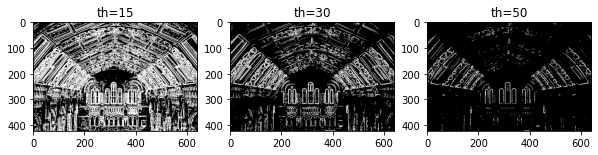

In [15]:
I = cv2.imread("./images/museum.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY).astype("float")

plt.subplot(131)
plt.title("th=15")
Ie = findedges(I, 1, 15)
plt.imshow(Ie, cmap="gray")

plt.subplot(132)
plt.title("th=30")
Ie = findedges(I, 1, 30)
plt.imshow(Ie, cmap="gray")

plt.subplot(133)
plt.title("th=50")
Ie = findedges(I, 1, 50)
plt.imshow(Ie, cmap="gray")

In [16]:
def nms(I, mask=None, sigma=1):
	pi = np.pi
	Imag, Idir = gradient_magnitude(I, sigma)
	if (mask is not None):
		Imag[1-mask] = 0
	Imag1, Idir1 = np.pad(Imag, 1), np.pad(Idir, 1)
	Imag2 = np.zeros_like(Imag1)
	for i in range(1, 1+I.shape[0]):
		for j in range(1, 1+I.shape[1]):
			d = Idir1[i,j]
			m = Imag1[i,j]
			if m == 0:
				continue
			
			if (d < -pi + pi/8 or d >= pi - pi/8) or (d >= -pi/8 and d < pi/8):
				if m > Imag1[i,j-1] and m > Imag1[i,j+1]:
					Imag2[i,j] = m
			if (d >= -3*pi/4 - pi/8 and d < -3*pi/4 + pi/8) or (d >= pi/4 - pi/8 and d < pi/4 + pi/8):
				if m > Imag1[i-1,j-1] and m > Imag1[i+1,j+1]:
					Imag2[i,j] = m
			if (d >= -pi/2 - pi/8 and d < -pi/2 + pi/8) or (d >= -pi/2 - pi/8 and d < -pi/2 + pi/8):
				if m > Imag1[i-1,j] and m > Imag1[i+1,j]:
					Imag2[i,j] = m
			if (d >= -pi/4 - pi/8 and d < -pi/4 + pi/8) or (d >= 3*pi/4 - pi/8 and d < 3*pi/4 + pi/8):
				if m > Imag1[i-1,j+1] and m > Imag1[i+1,j-1]:
					Imag2[i,j] = m
	return Imag2[1:-1, 1:-1]

def threshold(I, theta):
	Ie = np.zeros_like(I)
	Ie[I >= theta] = 1
	return Ie.astype("int")
	

In [ ]:
th = 25
Ie = findedges(I, 1, th)
Inms = nms(I, Ie)
Inms2 = threshold(Inms, th)

plt.rcParams["figure.figsize"] = (20,7)
plt.subplot(121)
plt.title("Thr.")
plt.imshow(Ie, cmap="gray")

plt.subplot(122)
plt.title("NMS")
plt.imshow(Inms2, cmap="gray")

## BONUS

In [18]:
def hysteresis(Inms, t_high, t_low):
	Ih = np.zeros_like(Inms).astype("uint8")
	Ih[Inms>=t_high] = 1
	Il = np.zeros_like(Ih)
	Il[Inms>=t_low] = 1
	c = cv2.connectedComponentsWithStats(Il)
	for i in range(c[0]):
		if np.sum(Ih*(c[1] == i)) > 0:
			Ih[(c[1] == i)] = 1
	return Ih

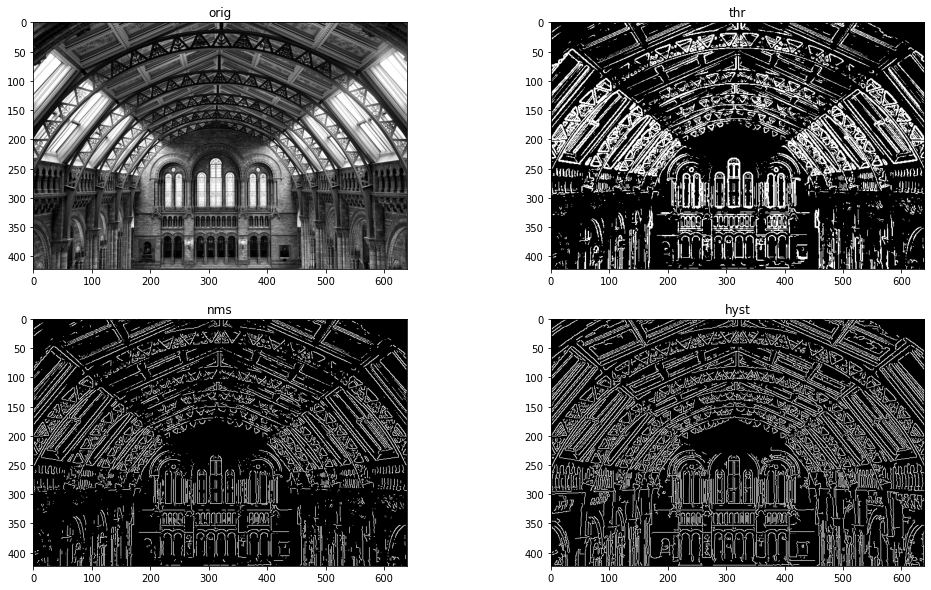

In [19]:
Ih = hysteresis(Inms, 25, 10)


plt.rcParams["figure.figsize"] = (17, 10)

plt.subplot(221)
plt.title("orig")
plt.imshow(I, cmap="gray")

plt.subplot(222)
plt.title("thr")
plt.imshow(Ie, cmap="gray")

plt.subplot(223)
plt.title("nms")
plt.imshow(Inms2, cmap="gray")

plt.subplot(224)
plt.title("hyst")
plt.imshow(Ih, cmap="gray")

---

# Exercise 3: Detecting lines

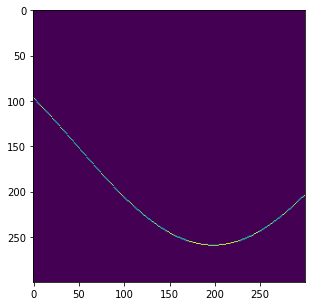

In [20]:
img = np.zeros((100,100))
img[50,90] = 1

res = 300
max_rho = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
acc = np.zeros((res, res))
for i in range(img.shape[0]):
	for j in range(img.shape[1]):
		if (img[i,j] == 1):
			for k in range(res):
				theta = (float(k)/float(res))*np.pi - np.pi/2
				rho = (j*np.cos(theta) + i*np.sin(theta) + max_rho)/(2*max_rho) * res
				acc[int(rho), k] += 1


plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(acc)

In [21]:
def hough_find_lines(img, n_bins_th, n_bins_rho, thr):
	res = 300
	max_rho = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
	A = np.zeros((n_bins_rho, n_bins_th))
	for i in range(img.shape[0]):
		for j in range(img.shape[1]):
			if (img[i,j] == 1):
				for k in range(n_bins_th):
					theta = (float(k)/float(n_bins_th))*np.pi - np.pi/2
					rho = (j*np.cos(theta) + i*np.sin(theta) + max_rho)/(2*max_rho) * n_bins_rho
					A[int(rho), k] += 1
	return A

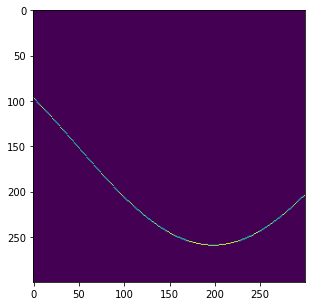

In [22]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(hough_find_lines(img, 300, 300, 0))

In [23]:
I1 = cv2.imread("./images/oneline.png")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY).astype("float")
I1e = findedges(I1, 1, 10)
I1h = hough_find_lines(I1e, 200, 300, 1)

I2 = cv2.imread("./images/rectangle.png")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY).astype("float")
I2e = findedges(I2, 1, 10)
I2h = hough_find_lines(I2e, 200, 300, 1)


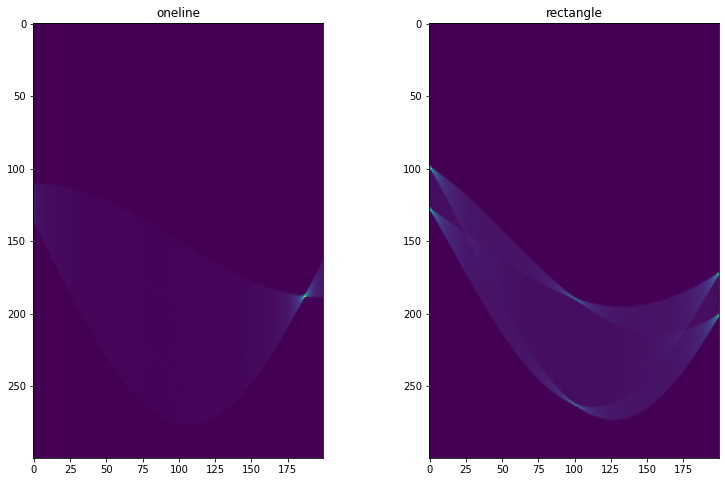

In [24]:
plt.rcParams["figure.figsize"] = (13, 8)
plt.subplot(121)
plt.title("oneline")
plt.imshow(I1h)
plt.subplot(122)
plt.title("rectangle")
plt.imshow(I2h)

In [25]:
def nonmaxima_suppression_box(Ih):
	Ih1 = np.pad(Ih, 1)
	Ih2 = np.zeros_like(Ih1)
	for i in range(1, 1+Ih.shape[0]):
		for j in range(1, 1+Ih.shape[1]):
			m = Ih1[i,j]
			if m == 0:
				continue
			
			if m >= np.max(Ih1[i-1:i+2, j-1:j+2]):
				Ih2[i,j] = m
	return Ih2[1:-1, 1:-1]

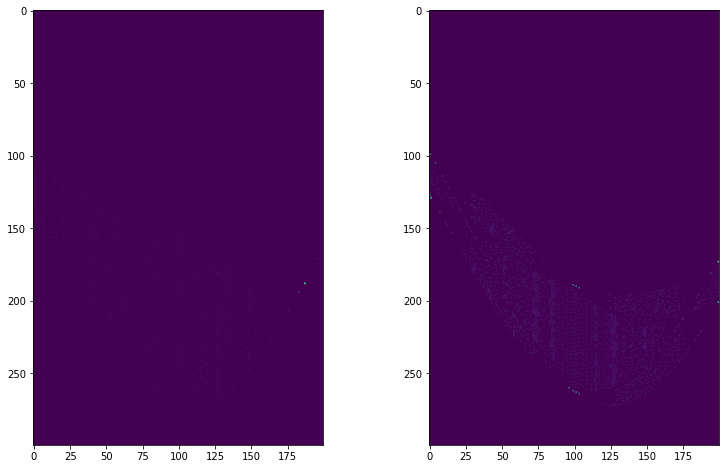

In [26]:
I1hnms = nonmaxima_suppression_box(I1h)
I2hnms = nonmaxima_suppression_box(I2h)
plt.subplot(121)
plt.imshow(I1hnms)
plt.subplot(122)
plt.imshow(I2hnms)

In [27]:
import a3_utils

In [28]:

def draw_line(rho, theta, max_rho, max_y):
	a = np.cos(theta)
	b = np.sin(theta)

	x0 = a*rho
	y0 = b*rho

	x1 = int(x0 + max_rho*(-b))
	y1 = int(y0 + max_rho*(a))
	x2 = int(x0 - max_rho*(-b))
	y2 = int(y0 - max_rho*(a))

	plt.plot((x1,x2),(max_y - y1,max_y -y2),'r')
	
def lines_above_th(Ih, th, max_rho, max_y):
	for i in range(Ih.shape[0]):
		for j in range(Ih.shape[1]):
			if Ih[i,j] >= th:
				draw_line((2*i/Ih.shape[0] - 1)*max_rho, (j/Ih.shape[1])*np.pi - np.pi/2, max_rho, max_y)

In [29]:
def draw_lines(I, Ih, th):
	max_rho = np.sqrt(I.shape[0]**2 + I.shape[1]**2)
	plt.xlim(0, I.shape[1])
	plt.ylim(0, I.shape[0])
	lines_above_th(Ih, th, max_rho, I.shape[0])
	plt.imshow(I[::-1, :])

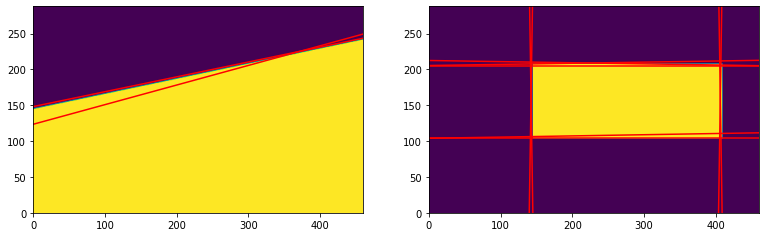

In [30]:
plt.subplot(121)
draw_lines(I1, I1hnms, 130)
plt.subplot(122)
draw_lines(I2, I2hnms, 300)

In [31]:
I1 = cv2.imread("./images/bricks.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY).astype("float")
I1e = findedges(I1, 1, 50)
I1h = hough_find_lines(I1e, 200, 800, 1)
print(1)
I2 = cv2.imread("./images/pier.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY).astype("float")
I2e = findedges(I2, 1, 15)
I2e = nms(I2, I2e, 1)
I2e = threshold(I2e, 15)
I2h = hough_find_lines(I2e, 200, 800, 1)

1


In [ ]:
I1hnms = nonmaxima_suppression_box(I1h)
I2hnms = nonmaxima_suppression_box(I2h)

plt.rcParams["figure.figsize"] = (13, 15)
plt.subplot(221)
plt.imshow(I1h, aspect='auto')
plt.subplot(222)
plt.imshow(I2h, aspect='auto')

I1c = cv2.imread("./images/bricks.jpg")
I1c = cv2.cvtColor(I1c, cv2.COLOR_BGR2RGB)

I2c = cv2.imread("./images/pier.jpg")
I2c = cv2.cvtColor(I2c, cv2.COLOR_BGR2RGB)

plt.subplot(223)
I1m = np.zeros_like(I1hnms)
nth = np.partition(I1hnms.flatten(), -10)[-10]
I1m[I1hnms >= nth] = 1
draw_lines(I1c, I1m, 1)
plt.subplot(224)
I2m = np.zeros_like(I2hnms)
nth = np.partition(I2hnms.flatten(), -10)[-10]
I2m[I2hnms >= nth] = 1
draw_lines(I2c, I2m, 1)